# LastFM Output Analysis

This notebook contains our analysis of the recommender evaluation results.

It proceeds in a few steps:

1. [Setup](#Setup), where we do the initial R configuration
2. [Read Data](#Read-Data), where we load in the experiment data for analysis
3. [Controlling for Profile Size](#Controlling-for-Profile-Size), where we model accuracy as a function of user profile size in order to control for intrinsic profile difficulty
4. [Gender](#Gender), where we analyze the results by gender.
5. [Age](#Age), where we analyze the results by age.

## Setup

Libraries:

In [1]:
library(plyr)
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)
source("plot-tools.R")

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Options:

In [3]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

Copy in the `bound_ages` function from the input analysis:

In [4]:
ml_age_lbs = c(1, 18, 25, 35, 45, 50, 56)
bound_ages = function(ages, bounds=ml_age_lbs) {
    ages[ages <= 0] = NA
    selectors = rowSums(outer(ages, ml_age_lbs, ">="))
    factor(ml_age_lbs[selectors], levels=as.character(bounds))
}

## Read Data

First, we need to read the user data from the underlying Last.FM data:

In [5]:
users.meta.360k = read_csv("build/lastfm-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)
users.meta.360k

Parsed with column specification:
cols(
  id = col_integer(),
  key = col_character(),
  gender = col_character(),
  age = col_integer()
)


user,gender,age
1,F,18
2,F,NA
3,NA,NA
4,M,18
5,M,25
⋮,⋮,⋮
359343,M,25
359344,M,25
359345,M,18
359346,M,18


In [6]:
users.meta.1k = read_csv("build/lfm1k-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)
users.meta.1k

Parsed with column specification:
cols(
  id = col_integer(),
  gender = col_character(),
  age = col_integer()
)


user,gender,age
1,M,NA
2,F,NA
3,M,18
4,F,NA
5,M,NA
⋮,⋮,⋮
988,F,NA
989,M,NA
990,M,NA
991,F,NA


In [7]:
users.meta = bind_rows(LFM360K=users.meta.360k, LFM1K=users.meta.1k, .id="DataSet")

Now, we want to get user profile statistics. In order to do that, we need each user's train profile; we can load that from the training data output by the cross-folding process.

For each partition, we need to load the _train ratings_ (historical profile) for all the _test users_ in that partition. So we will load the test data (to get the users) and the train data (to get the histories), then merge them.

In [8]:
train.ratings.360k = ldply(1:5, function(part) {
    message("reading part ", part)
    test.fn = sprintf("build/lastfm-splits/u.part%d.test.csv", part)
    train.fn = sprintf("build/lastfm-splits/u.part%d.train.csv", part)
    test = suppressMessages(read_csv(test.fn))
    train = suppressMessages(read_csv(train.fn))
    test %>%
        select(user) %>%
        distinct() %>%
        mutate(part=as.factor(part)) %>%
        inner_join(train)
})
head(train.ratings.360k)

reading part 1
Joining, by = "user"
reading part 2
Joining, by = "user"
reading part 3
Joining, by = "user"
reading part 4
Joining, by = "user"
reading part 5
Joining, by = "user"


user,part,item,count
51,1,417,1162
51,1,278,365
51,1,355,320
51,1,1753,246
51,1,1491,218
51,1,1754,202


In [9]:
train.ratings.1k = ldply(1:5, function(part) {
    message("reading part ", part)
    test.fn = sprintf("build/lfm1k-splits/u.part%d.test.csv", part)
    train.fn = sprintf("build/lfm1k-splits/u.part%d.train.csv", part)
    test = suppressMessages(read_csv(test.fn))
    train = suppressMessages(read_csv(train.fn))
    test %>%
        select(user) %>%
        distinct() %>%
        mutate(part=as.factor(part)) %>%
        inner_join(train)
})
head(train.ratings.1k)

reading part 1
Joining, by = "user"
reading part 2
Joining, by = "user"
reading part 3
Joining, by = "user"
reading part 4
Joining, by = "user"
reading part 5
Joining, by = "user"


user,part,item,count
3,1,2174,8
3,1,2167,3
3,1,2426,3
3,1,2143,7
3,1,2179,1
3,1,2683,7


In [10]:
train.ratings =
    bind_rows(LFM360K = train.ratings.360k,
              LFM1K = train.ratings.1k,
              .id="DataSet") %>%
    mutate(DataSet = as.factor(DataSet))

Quick summary just to see what this data looks like:

In [11]:
train.ratings %>%
    select(DataSet, part, count) %>%
    summary()

    DataSet        part           count         
 LFM1K  : 899662   1:398641   Min.   :     1.0  
 LFM360K:1097307   2:390195   1st Qu.:     3.0  
                   3:407456   Median :    26.0  
                   4:397234   Mean   :   128.3  
                   5:403443   3rd Qu.:   122.0  
                              Max.   :134993.0  

Now we want to compute per-user profile statistics:

In [12]:
user.stats = train.ratings %>%
    group_by(DataSet, user) %>%
    summarize(nartists = n(), meanPlays=mean(count), medPlays=median(count), totalPlays=sum(count))
user.stats

DataSet,user,nartists,meanPlays,medPlays,totalPlays
LFM1K,1,658,25.16109,4,16556
LFM1K,2,1287,44.30148,5,57016
LFM1K,3,940,20.65106,4,19412
LFM1K,4,1774,10.34837,3,18358
LFM1K,5,1081,18.79556,3,20318
⋮,⋮,⋮,⋮,⋮,⋮
LFM360K,359322,49,71.87755,61.0,3522
LFM360K,359324,44,12.79545,5.5,563
LFM360K,359332,44,307.75000,229.0,13541
LFM360K,359344,43,238.06977,67.0,10237


Join these statistics with our user metadata table, so that we have one table of user information:

In [13]:
users = users.meta %>% inner_join(user.stats)
users

Joining, by = c("DataSet", "user")
Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

DataSet,user,gender,age,nartists,meanPlays,medPlays,totalPlays
LFM360K,39,F,18,38,1.763158,1.0,67
LFM360K,51,M,25,69,116.043478,92.0,8007
LFM360K,63,M,18,39,259.102564,66.0,10105
LFM360K,77,M,18,45,589.888889,432.0,26545
LFM360K,86,F,25,48,137.604167,97.5,6605
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM1K,988,F,NA,145,33.64138,10,4878
LFM1K,989,M,NA,124,74.78226,3,9273
LFM1K,990,M,NA,599,55.97162,7,33527
LFM1K,991,F,NA,507,61.50493,5,31183


Now that we have user information, we can read the per-user recommender evaluation results.

In [14]:
user.results.360k = read_csv("build/lastfm-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    mutate(DataSet = "LFM360K")
user.results.360k %>% select(nDCG, RecipRank, AvgPrec) %>% summary()

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  L10K.Rank = col_integer(),
  Rank = col_integer()
)
See spec(...) for full column specifications.


      nDCG           RecipRank            AvgPrec     
 Min.   :0.00000   Min.   :0.0000000   Min.   :0.00   
 1st Qu.:0.07097   1st Qu.:0.0000242   1st Qu.:0.00   
 Median :0.09640   Median :0.0004854   Median :0.00   
 Mean   :0.13339   Mean   :0.0963869   Mean   :0.04   
 3rd Qu.:0.16267   3rd Qu.:0.0312500   3rd Qu.:0.03   
 Max.   :0.99924   Max.   :1.0000000   Max.   :1.00   
                                       NA's   :50000  

In [15]:
user.results.1k = read_csv("build/lfm1k-user-results.csv") %>%
    rename(user=User)
user.results.1k %>% select(nDCG, RecipRank, AvgPrec) %>% summary()

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  L10K.Rank = col_integer(),
  Rank = col_integer()
)
See spec(...) for full column specifications.


      nDCG           RecipRank            AvgPrec      
 Min.   :0.00000   Min.   :0.0000000   Min.   :0.0000  
 1st Qu.:0.03528   1st Qu.:0.0000363   1st Qu.:0.0002  
 Median :0.08315   Median :0.0008787   Median :0.0014  
 Mean   :0.09686   Mean   :0.0419966   Mean   :0.0155  
 3rd Qu.:0.11749   3rd Qu.:0.0098039   3rd Qu.:0.0076  
 Max.   :0.98424   Max.   :1.0000000   Max.   :0.9167  
                                       NA's   :1962    

In [37]:
user.results = bind_rows(user.results.360k, user.results.1k) %>%
    mutate(DataSet=as.factor(DataSet),
           Algorithm=as.factor(Algorithm)) %>%
    inner_join(users)
user.results

Joining, by = c("DataSet", "user")
Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

DataSet,Partition,Algorithm,user,TestTime,Rank.nDCG,L100.Rank,L100.RecipRank,L100.nDCG,L100.AvgPrec,⋯,Rank,RecipRank,nDCG,AvgPrec,gender,age,nartists,meanPlays,medPlays,totalPlays
LFM360K,3,UU-B,240341,1.024,0,NA,0,0,NA,⋯,NA,0,0,NA,M,25,43,176.44186,142,7587
LFM360K,3,UU-C,240341,1.161,0,NA,0,0,NA,⋯,NA,0,0,NA,M,25,43,176.44186,142,7587
LFM360K,4,UU-C,242717,0.724,0,NA,0,0,NA,⋯,NA,0,0,NA,M,25,43,306.53488,192,13181
LFM360K,4,UU-C,242766,0.732,0,NA,0,0,NA,⋯,NA,0,0,NA,M,25,45,66.82222,54,3007
LFM360K,5,UU-B,236784,0.792,0,NA,0,0,NA,⋯,NA,0,0,NA,M,18,47,334.40426,224,15717
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM1K,1,II-B,531,6.733,0.8790780,NA,0.00000000,0.0000000,0.00000000,⋯,687,0.0014556041,0.09036178,5.185396e-04,NA,NA,2025,1.821728,1,3689
LFM1K,1,II-B,235,4.315,0.8924490,55,0.01818182,0.1061252,0.02007992,⋯,55,0.0181818182,0.15043740,1.170296e-02,NA,25,1073,35.768872,4,38380
LFM1K,1,II-B,793,11.716,0.5856374,NA,0.00000000,0.0000000,0.00000000,⋯,7973,0.0001254233,0.04178119,9.837568e-05,NA,NA,4365,32.501031,4,141867
LFM1K,1,II-B,162,4.841,0.7769084,NA,0.00000000,0.0000000,0.00000000,⋯,389,0.0025706941,0.10495443,2.949473e-03,F,45,1276,23.085423,16,29457


In [38]:
write_csv(user.results, "build/lfm-integrated-user-results.csv")

## Gender

Let's analyze accuracy by gender.

In [26]:
gender.results = user.results %>%
    select(DataSet, Algorithm, gender, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", -DataSet, -Algorithm, -gender) %>%
    group_by(DataSet, Algorithm, gender, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup() %>%
    mutate(gender=ifelse(is.na(gender), "?", as.character(gender)))
gender.results

DataSet,Algorithm,gender,Metric,value
LFM1K,II-B,F,MAP,0.03713482
LFM1K,II-B,F,MRR,0.12405558
LFM1K,II-B,F,nDCG,0.18379674
LFM1K,II-B,F,Rank.nDCG,0.82341261
LFM1K,II-B,M,MAP,0.02250874
⋮,⋮,⋮,⋮,⋮
LFM360K,UU-C,M,Rank.nDCG,0
LFM360K,UU-C,?,MAP,NA
LFM360K,UU-C,?,MRR,0
LFM360K,UU-C,?,nDCG,0


In [27]:
overall.results = user.results %>%
    select(DataSet, Algorithm, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", -DataSet, -Algorithm) %>%
    group_by(DataSet, Algorithm, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup() %>%
    mutate(gender = 'Any')
combined.results = rbind(gender.results, overall.results) %>%
    mutate(gender=factor(gender, levels=c("F", "M", "?", "Any"), ordered=TRUE))
head(combined.results)

DataSet,Algorithm,gender,Metric,value
LFM1K,II-B,F,MAP,0.03713482
LFM1K,II-B,F,MRR,0.12405558
LFM1K,II-B,F,nDCG,0.18379674
LFM1K,II-B,F,Rank.nDCG,0.82341261
LFM1K,II-B,M,MAP,0.02250874
LFM1K,II-B,M,MRR,0.07704965


Warning message:
“Removed 16 rows containing missing values (geom_bar).”

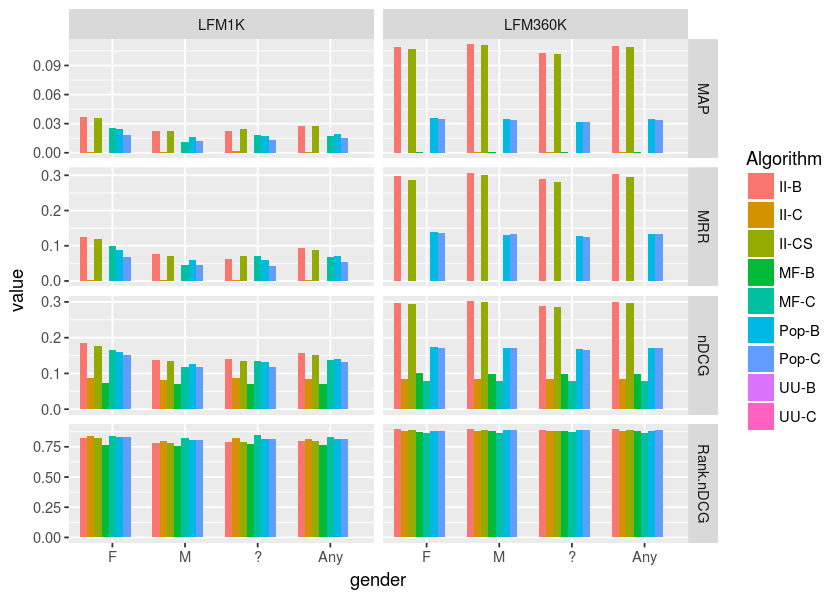

In [28]:
ggplot(combined.results) +
    aes(x=gender, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_grid(Metric ~ DataSet, scales="free")

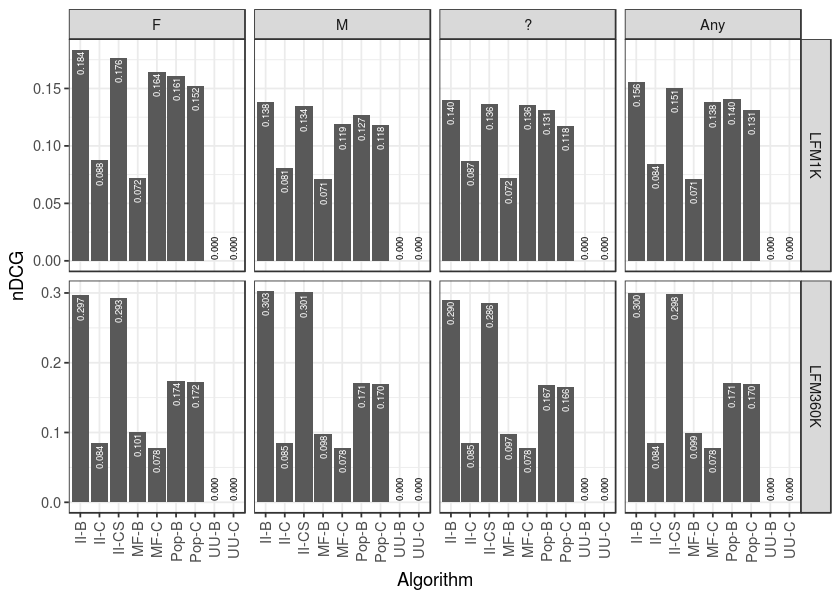

In [29]:
make.plot("lastfm-gender-ndcg", width=5, height=3, {
    ggplot(combined.results %>% filter(Metric == "nDCG")) +
        aes(x=Algorithm, y=value) +
        geom_bar(stat="identity") +
        geom_text(mapping=aes(label=sprintf("%.03f", value),
                              hjust=ifelse(value > 0.025, 1.1, -0.05),
                              color=ifelse(value > 0.025, "white", "black")),
                  size=2, vjust=0.5, angle=90) +
        scale_color_identity() +
        facet_grid(DataSet ~ gender, scales="free_y") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("nDCG")
})

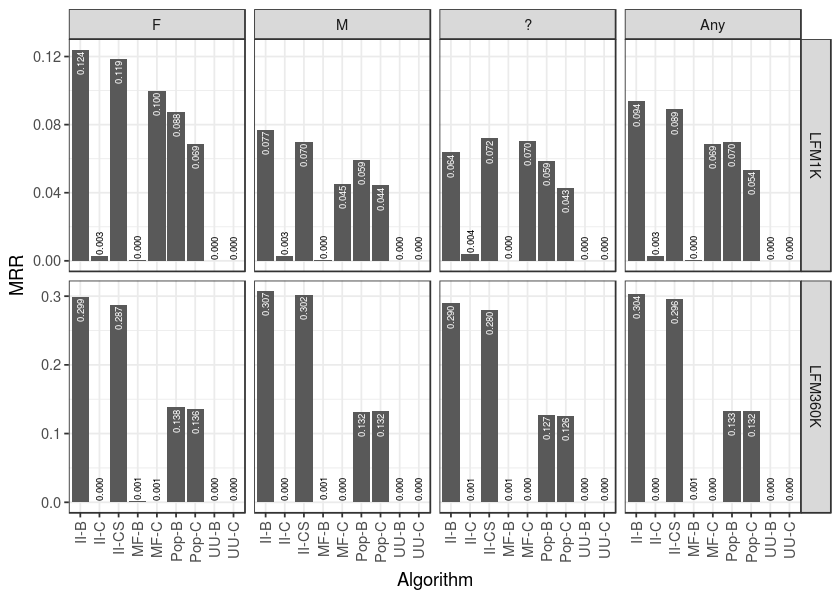

In [30]:
make.plot("lastfm-gender-mrr", width=5, height=3, {
    ggplot(combined.results %>% filter(Metric == "MRR")) +
        aes(x=Algorithm, y=value) +
        geom_bar(stat="identity") +
        geom_text(mapping=aes(label=sprintf("%.03f", value),
                              hjust=ifelse(value > 0.025, 1.1, -0.05),
                              color=ifelse(value > 0.025, "white", "black")),
                  size=2, vjust=0.5, angle=90) +
        scale_color_identity() +
        facet_grid(DataSet ~ gender, scales="free_y") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("MRR")
})

## Age

Now we wish to do the same thing by age.

In [33]:
age.results = user.results %>%
    select(DataSet, Algorithm, age, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", MAP, MRR, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm, age, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup()
age.results

DataSet,Algorithm,age,Metric,value
LFM1K,II-B,1,MAP,0.01901359
LFM1K,II-B,1,MRR,0.06888746
LFM1K,II-B,1,nDCG,0.17420873
LFM1K,II-B,1,Rank.nDCG,0.76940890
LFM1K,II-B,18,MAP,0.02395457
⋮,⋮,⋮,⋮,⋮
LFM360K,UU-C,56,Rank.nDCG,0
LFM360K,UU-C,NA,MAP,NA
LFM360K,UU-C,NA,MRR,0
LFM360K,UU-C,NA,nDCG,0


In [34]:
overall.results = user.results %>%
    select(DataSet, Algorithm, MAP=AvgPrec, MRR=RecipRank, nDCG, Rank.nDCG) %>%
    gather("Metric", "value", MAP, MRR, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup() %>%
    mutate(age = 'Any')
age.combined.results = rbind(age.results, overall.results) %>%
    filter(DataSet == "LFM360K")
head(age.combined.results)

DataSet,Algorithm,age,Metric,value
LFM360K,II-B,1,MAP,0.1319897
LFM360K,II-B,1,MRR,0.3489934
LFM360K,II-B,1,nDCG,0.3274948
LFM360K,II-B,1,Rank.nDCG,0.8846720
LFM360K,II-B,18,MAP,0.1136501
LFM360K,II-B,18,MRR,0.3154928


Warning message:
“Removed 18 rows containing missing values (geom_bar).”

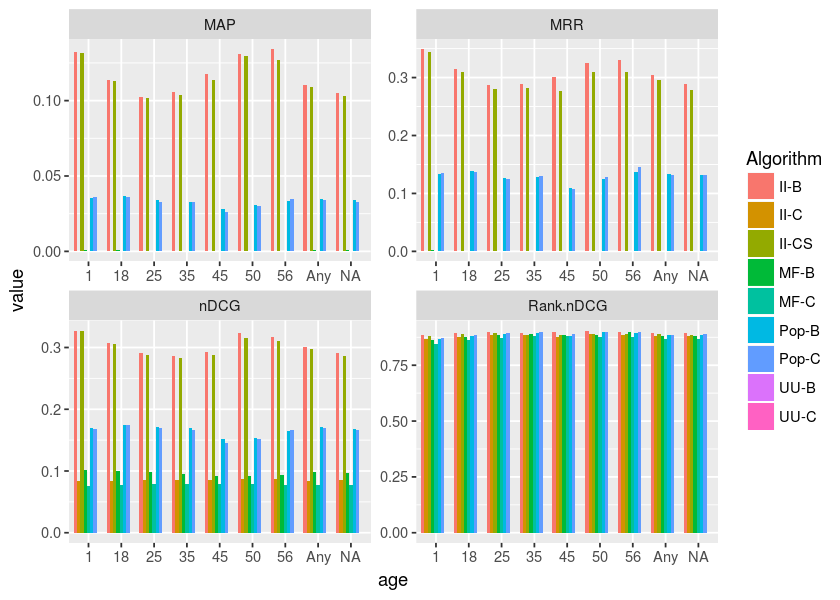

In [35]:
ggplot(age.combined.results) +
    aes(x=age, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_wrap(~ Metric, scales="free")